## Setup

In [ ]:
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from weis.visualization.utils import load_OMsql_multi
from rosco.toolbox.ofTools.fast_io import output_processing
from cmcrameri import cm
from my_plot_settings import *

%matplotlib widget

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.DeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/pkg_resources/__init__.py:3146
Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packagesDeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/jsonmerge/__init__.py:27
Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.PendingDeprecati

In [3]:
def interpolate_at_azimuth(azimuth, signal, target_azimuth):
    """Interpolate signal at specific azimuth angle for each rotor revolution."""
    azimuth = np.asarray(azimuth)
    signal = np.asarray(signal)
    interpolated_values = []

    for i in range(len(azimuth) - 1):
        az_curr = azimuth[i]
        az_next = azimuth[i + 1]

        if az_curr < target_azimuth <= az_next:
            fraction = (target_azimuth - az_curr) / (az_next - az_curr)
            interp_value = signal[i] + fraction * (signal[i + 1] - signal[i])
            interpolated_values.append(interp_value)

    return interpolated_values

## Load Data

In [4]:
# Paths
base_path = "../../data/design_of_experiments/ps_vs_ipc_harmonics2/openfast_runs"
log_path = "../../data/design_of_experiments/ps_vs_ipc_harmonics2/log_ps_vs_ipc_harmonics2.sql*"

# Load metadata (rank -> n_harmonics mapping)
print("Loading metadata...")
data_dict = load_OMsql_multi(log_path)
df_meta = pd.DataFrame(
    {
        "rank": data_dict["rank"],
        "iter": data_dict["iter"],
        "n_harmonics": data_dict["tune_rosco_ivc.TCIPC_nHarmonics"],
    }
)
print(f"Available n_harmonics: {sorted(df_meta['n_harmonics'].unique())}")

Loading metadata...


This process (pid=10783) is multi-threaded, use of fork() may lead to deadlocks in the child.

Available n_harmonics: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0000000000000004), np.float64(4.0), np.float64(5.0), np.float64(6.000000000000001), np.float64(7.000000000000001), np.float64(8.0), np.float64(9.0)]


In [5]:
# Load OpenFAST output files (.outb)
print("\nLoading OpenFAST outputs...")
outb_files = sorted(glob.glob(os.path.join(base_path, "rank_*/*.outb")))
op_openfast = output_processing.output_processing()
openfast_data = op_openfast.load_fast_out(outb_files, tmin=0, verbose=False)
print(f"Loaded {len(openfast_data)} OpenFAST files")


Loading OpenFAST outputs...


This process (pid=10783) is multi-threaded, use of fork() may lead to deadlocks in the child.

Loaded 10 OpenFAST files


In [6]:
# Load ROSCO debug files (.RO.dbg)
print("\nLoading ROSCO debug files...")
dbg_files = sorted(glob.glob(os.path.join(base_path, "rank_*/*.RO.dbg")))
op_rosco = output_processing.output_processing()
rosco_data = op_rosco.load_fast_out(dbg_files, tmin=0, verbose=False)
print(f"Loaded {len(rosco_data)} ROSCO debug files")

# Verify TipDxc_TowerPas exists
if "TipDxc_TowerPas" in rosco_data[0]["meta"]["channels"]:
    print("✓ TipDxc_TowerPas column found")
else:
    print("✗ WARNING: TipDxc_TowerPas column not found!")


Loading ROSCO debug files...
Loaded 10 ROSCO debug files
✓ TipDxc_TowerPas column found


## Step 1: Compute Ground Truth (Single Value)

Calculate mean tower-passing deflection across all blades and all simulations.

In [7]:
# Tower passing azimuths
tower_azimuths = {1: 180.0, 2: 60.0, 3: 300.0}

# Collect all tower-passing deflection means
all_tower_passing_means = []

for openfast_dict in openfast_data:
    azimuth = openfast_dict["Azimuth"]
    tipdxc1 = openfast_dict["TipDxc1"]
    tipdxc2 = openfast_dict["TipDxc2"]
    tipdxc3 = openfast_dict["TipDxc3"]

    # Interpolate each blade at its tower-passing azimuth
    blade1_tp = interpolate_at_azimuth(azimuth, tipdxc1, tower_azimuths[1])
    blade2_tp = interpolate_at_azimuth(azimuth, tipdxc2, tower_azimuths[2])
    blade3_tp = interpolate_at_azimuth(azimuth, tipdxc3, tower_azimuths[3])

    # Mean of three blades for each tower-passing event
    n_events = min(len(blade1_tp), len(blade2_tp), len(blade3_tp))
    for j in range(n_events):
        event_mean = (blade1_tp[j] + blade2_tp[j] + blade3_tp[j]) / 3.0
        all_tower_passing_means.append(event_mean)

# Overall ground truth
ground_truth = np.mean(all_tower_passing_means)
ground_truth_std = np.std(all_tower_passing_means)

print(f"\n{'=' * 60}")
print(f"GROUND TRUTH: {ground_truth:.6f} m")
print(f"Std deviation: {ground_truth_std:.6f} m")
print(f"Tower-passing events: {len(all_tower_passing_means)}")
print(f"{'=' * 60}")


GROUND TRUTH: 12.660413 m
Std deviation: 0.002286 m
Tower-passing events: 110


## Step 2: Build Comparison DataFrame

Extract all controller estimates and compute errors (time > 300s only).

In [8]:
data_rows = []

for rosco_dict in rosco_data:
    # Extract rank from filename
    filename = rosco_dict["meta"]["filename"]
    match = re.search(r"rank_(\d+)", filename)
    if not match:
        continue
    rank = int(match.group(1))

    # Get n_harmonics for this rank
    meta_subset = df_meta[(df_meta["rank"] == rank) & (df_meta["iter"] == 0)]
    if len(meta_subset) == 0:
        continue
    n_harmonics = int(meta_subset["n_harmonics"].values[0])

    # Extract all controller estimates (only time > 300s)
    time = rosco_dict["Time"]
    controller_estimate = rosco_dict["TipDxc_TowerPas"]

    # Create rows for time samples > 300s
    for t, est in zip(time, controller_estimate):
        if t > 300:
            data_rows.append(
                {
                    "rank": rank,
                    "n_harmonics": n_harmonics,
                    "time": t,
                    "controller_estimate": est,
                    "ground_truth": ground_truth,
                    "error": ground_truth - est,
                }
            )

df = pd.DataFrame(data_rows)
print(f"\nDataFrame shape: {df.shape}")
print(f"Time samples per simulation: ~{len(df) // len(rosco_data)}")
print(f"\nError summary by n_harmonics:")
print(df.groupby("n_harmonics")["error"].describe())


DataFrame shape: (40000, 6)
Time samples per simulation: ~4000

Error summary by n_harmonics:
              count      mean       std       min       25%       50%  \
n_harmonics                                                             
0            4000.0 -0.742274  0.002889 -0.749787 -0.744387 -0.742187   
1            4000.0 -0.062348  0.006152 -0.076787 -0.066687 -0.063037   
2            4000.0  0.025105  0.011068  0.009413  0.017213  0.021613   
3            4000.0  0.034933  0.188737 -0.259187 -0.159912  0.041113   
4            4000.0  0.030481  0.184056 -0.264387 -0.160637  0.031763   
5            4000.0  0.024352  0.184151 -0.269687 -0.157612  0.007563   
6            4000.0  0.016797  0.314106 -0.662187 -0.129687  0.058163   
7            4000.0  0.009527  0.309694 -0.677087 -0.140587  0.055163   
8            4000.0  0.005567  0.311469 -0.682487 -0.170612  0.041363   
9            4000.0  0.001102  0.551366 -1.362587 -0.274737  0.061713   

                  75%       

## Visualizations

Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.

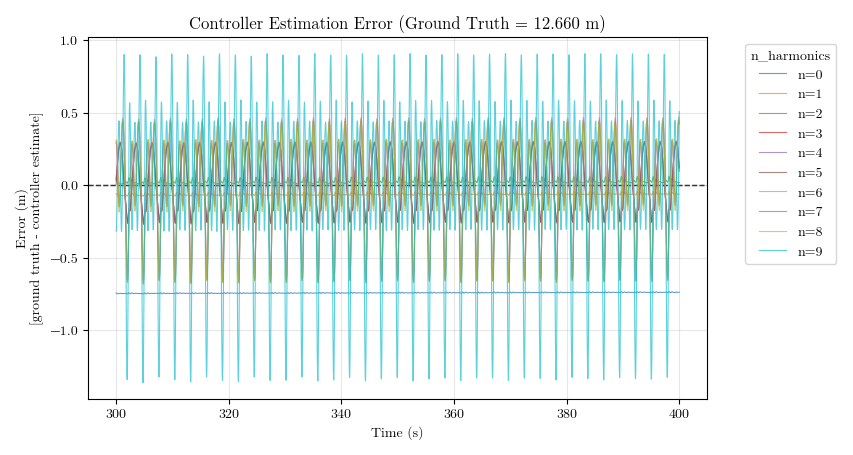

In [9]:
# Time-domain plot
fig, ax = plt.subplots(figsize=(default_fig_width * 1.5, default_fig_width * 0.8))

for n_harm in sorted(df["n_harmonics"].unique()):
    df_sub = df[df["n_harmonics"] == n_harm]
    ax.plot(
        df_sub["time"],
        df_sub["error"],
        alpha=0.7,
        linewidth=0.8,
        label=f"n={int(n_harm)}",
    )

ax.axhline(0, color="k", linestyle="--", linewidth=1, zorder=1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Error (m)\n[ground truth - controller estimate]")
ax.set_title(f"Controller Estimation Error (Ground Truth = {ground_truth:.3f} m)")
ax.grid(alpha=0.3)
ax.legend(title="n_harmonics", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.

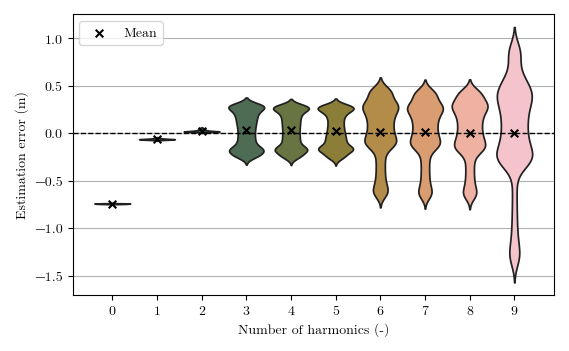

In [ ]:
# Violin plot with mean markers
fig, ax = plt.subplots()

sns.violinplot(
    data=df,
    x="n_harmonics",
    y="error",
    ax=ax,
    palette="cmc.batlow",
    inner=None,
)

# Add mean values as circles
mean_errors = df.groupby("n_harmonics")["error"].mean()
ax.scatter(
    range(len(mean_errors)),
    mean_errors.values,
    color="black",
    marker="x",
    s=30,
    zorder=10,
    label="Mean",
)

ax.axhline(0, color="k", linestyle="--", linewidth=1, zorder=10)
ax.set_axisbelow(True)
ax.set_xlabel("Number of harmonics (-)")
ax.set_ylabel("Estimation error (m)")
ax.grid(axis="y")
ax.legend()

plt.tight_layout()
plt.show()

plt.savefig("figures/nHarmonics.pdf")

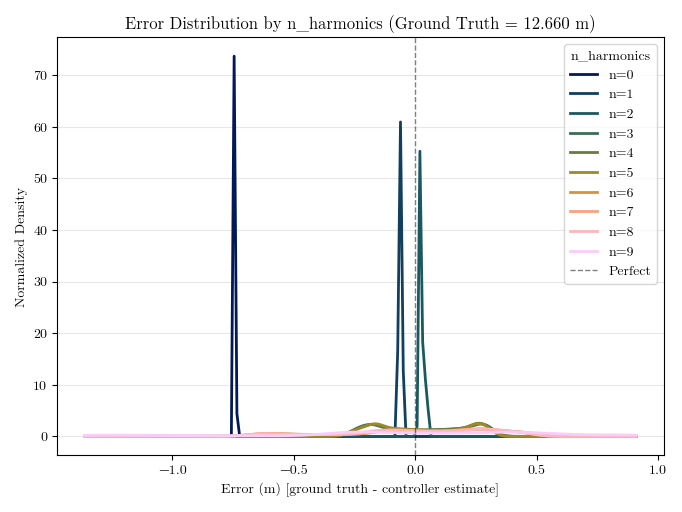

In [ ]:
# PDF plot (probability density function) with normalization and shared x-range
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(default_fig_width * 1.2, default_fig_width * 0.9))

# Global x-range from all errors
global_errors = df["error"].values
x_min, x_max = np.min(global_errors), np.max(global_errors)
x_range = np.linspace(x_min, x_max, 200)

# Colormap
n_unique = len(df["n_harmonics"].unique())
colors = cm.batlow(np.linspace(0, 1, n_unique))

for idx, n_harm in enumerate(sorted(df["n_harmonics"].unique())):
    df_sub = df[df["n_harmonics"] == n_harm]
    errors = df_sub["error"].values

    # Compute KDE over shared x_range
    kde = gaussian_kde(errors)
    density = kde(x_range)

    ax.plot(
        x_range,
        density,
        linewidth=2,
        label=f"n={int(n_harm)}",
        color=colors[idx],
    )

ax.axvline(0, color="k", linestyle="--", linewidth=1, alpha=0.5, label="Perfect")
ax.set_xlabel("Error (m) [ground truth - controller estimate]")
ax.set_ylabel("Normalized Density")
ax.set_title(f"Error Distribution by n_harmonics (Ground Truth = {ground_truth:.3f} m)")
ax.grid(alpha=0.3, axis="y")
ax.legend(title="n_harmonics")

plt.tight_layout()
plt.show()
